In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('seaborn-v0_8-paper')
import itertools
import warnings
from zoneinfo import ZoneInfo
from functools import partial
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import pickle
import os

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.city_gen as cg
import nomad.traj_gen as tg
import nomad.filters as filters
from nomad.traj_gen import Agent, Population
from nomad.generation.sparsity import gen_params_target_q
import nomad.generation.viz as viz
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [2]:
# At some point, we should fix the warnings in the codebase, but for now we can ignore them.

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# The following functions help with segmenting the analysis to building size/type and stop dwell time. 

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'

# Robustness to sparsity in pre-processing of human mobility data

**Francisco Jose Barreras**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

**Thomas Li**, Graduate School of Business, Stanford University, Palo Alto, CA, USA

**Duncan Watts**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

## Abstract

Pre-processing algorithms for human mobility data, such as stop detection, are vulnerable to errors when applied to sparse and bursty GPS datasets, but evaluating their robustness is difficult in the absence of ground truth. We address this challenge with a synthetic benchmarking framework that combines an agent-based generator of realistic trajectories—based on the Exploration and Preferential Return model (EPR)—with a sparse sampler that replicates the temporal structure of real GPS data. This setup allows controlled comparison of algorithm outputs against known ground-truth stops. We evaluate three stop-detection methods—ST-DBScan, Lachesis, and a grid-based algorithm—across varying levels of sparsity, burstiness, and parameterizations. Our analysis identifies failure modes such as stop merging, splitting, and missed stops, quantifies how often they arise under realistic movement patterns, and assesses how parameter tuning can mitigate them. We find that commonly used algorithms are not robust to levels of sparsity commonly found in commercial datasets, and that parameter choices critically affect outcomes. These experiments offer practical guidance for improving the reliability of GPS data processing in applied research.

## Introduction

Commercial GPS datasets have become central to human mobility research, powering applications in epidemiology, disaster response, transportation, urban planning, and behavioral science \cite{chang2021mobility, pepe2020covid, couture2021jue, moro2021mobility, gauvin2020gender, song2014prediction}. These datasets provide granular, high-frequency location signals from smartphones, but they are also sparse, bursty, and noisy—particularly when pings are collected opportunistically via apps or under privacy-preserving constraints. To extract useful signals from these raw data, researchers apply pre-processing algorithms to identify stops, trips, and frequently visited locations. However, many of these algorithms, including variants of DBScan \cite{birant2007st, ester1996density}, rule-based methods like Project Lachesis \cite{hariharan2004project}, and grid-based heuristics, were not designed with sparse or bursty signals in mind. Their performance in such settings is rarely tested, and robustness to signal degradation remains poorly understood.

Evaluating robustness in these settings is nontrivial. Real datasets typically lack ground truth: it is unknown whether a detected stop reflects a real event, or if a missed stop is due to noise, sparsity, or poor parameterization. Even synthetic benchmarks often assume uniformly sampled trajectories, which overlook the temporal irregularities that characterize real data. As a result, existing evaluations often prioritize computational efficiency over behavioral accuracy \cite{aslak2020infostop, chen2014t}, leaving open questions about how well these algorithms perform under the kinds of signal degradation found in commercial datasets.

We address this challenge by introducing a synthetic benchmarking framework designed to test the robustness of stop-detection algorithms under realistic conditions. Our framework builds on the Garden City mobility model \cite{2412.00913v1}, which uses an Exploration and Preferential Return (EPR) model to simulate human mobility patterns at both macro and micro scales. Agents generate full, minute-level “ground-truth” trajectories as they move through a synthetic city composed of homes, workplaces, and public locations. These trajectories are then sparsified using a self-exciting point process that captures the bursty nature of GPS pings, and measurement noise is added to mimic GPS error. These sparse trajectories, alongside their ground-truth counterparts, allow us to quantify the accuracy and robustness of stop-detection algorithms used in the human mobility literature.

Using this framework, we evaluate the robustness of three stop-detection algorithms—ST-DBScan \cite{birant2007st}, Lachesis \cite{hariharan2004project}, and a simple grid-based method—by comparing their outputs to the ground-truth mobility diaries of the simulated agents. Our analysis proceeds in three parts. First, we characterize the failure modes of these algorithms using controlled synthetic trajectories, identifying phenomena such as stop merging (over-clustering), stop splitting (under-clustering), and omission of stops altogether. Second, we test whether these failure modes persist under more realistic mobility traces, and analyze their frequency and correlation with features of the signal such as ping density, burst structure, and location size. Finally, we show that careful parameter tuning can mitigate some—but not all—of these issues, and provide practical guidance on how to select parameters in the presence of sparse and noisy data.

Our results indicate that most stop-detection algorithms are not robust to realistic forms of sparsity, and that failure rates depend strongly on the temporal structure of the data—not just its average sampling rate. These findings underscore the need for more principled benchmarking and parameter selection in GPS data processing pipelines, especially for applications where downstream metrics are sensitive to stop detection.

## Possible errors in stop detection

We focus on errors of two types. Clustering pings that should not be clustered together, in particular, merging of two stops that occur in nearby buildings. This should occur more often when the algorithm parameters are coarser.
The other problem is failure to cluster pings that correspond to the same stop, this is a problem when the movement is to broad and the parameters are too fine, but also when there are long gaps in the data. Thus, we anticipate the error to be related to area and dwell times. We call these "missed stops" and "splitting"

**Ad-hoc trajectory 1**: 4 one-hour-long visits to nearby buildings.

$\varepsilon$: Stop-detection distance thresholds ($\varepsilon$) larger than the distance between two buildings guarantee merging. We experiment with $\varepsilon = 12m$ for DBScan, and $\varepsilon = 30m$ for Lachesis, to cover a non-trivial regime.

![Ad-hoc Trajectory 1](./ad-hoc-traj-1.png)

**Ad-hoc trajectory 2**:  5 visits to separate buildings, with varying areas and dwell times.

$\Delta T$: Stop-detection max allowed gap of 90 minutes is common and allows for splitting when dwelling for a long time. We experiment with $\varepsilon = 18m$ for DBSCan, and $\varepsilon = 30m$ for Lachesis, to allow some spatial splitting.

![Ad-hoc Trajectory 2](./ad-hoc-traj-2.png)

## START CODE

Begin by initiating the city and loading the table of POIs.

In [4]:
city = cg.load('../garden-city.pkl')

poi_table = gpd.read_file('../garden_city_gc_coords.geojson')
poi_table = poi_table.rename({'type':'building_type'}, axis=1)  # building type
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)  # building size

### Define the function for simulation

In [5]:
summarize_stops_with_loc = partial(
    utils.summarize_stop,
    x='x',
    y='y',
    keep_col_names=False,
    passthrough_cols=['building_id'],
    complete_output=True)

def run_simulation_for_single_seed(
    seed, dt, sim_tasks, agent_home, agent_workplace, destinations,
    dbscan_param, lachesis_param, traj_cols, summarize_stops_with_loc
):
    """
    This function performs the simulation for a single 'seed'.
    It can be run in parallel to speed up the process.

    Key Parameters
    ----------
    seed : int
        Random seed for generating the ground-truth trajectory.
        IMPORTANT: use a different seed for each process to avoid repetition.
    dt : int
        Time step in minutes for the trajectory generation.
    sim_tasks : pd.DataFrame
        DataFrame containing the simulation configurations to run for each seed. 
        Includes parameters (beta_start, beta_dur, beta_ping, algorithm, ha).
    agent_home, agent_workplace : str
        Identifiers for the agent's home and workplace buildings.
    destinations : pd.DataFrame
        DataFrame containing the destination diary for the agent.
    """
    # Initialize DataFrames to store metrics for this seed
    seed_all_metrics_df = pd.DataFrame()
    seed_metrics_size_df = pd.DataFrame()
    seed_metrics_btype_df = pd.DataFrame()
    seed_metrics_dwell_df = pd.DataFrame()

    # Initialize the agent and generate a trajectory with a destination diary
    agent = Agent(
        identifier="Charlie",
        home=agent_home,
        workplace=agent_workplace,
        city=city
    )
    agent.generate_trajectory(
        destination_diary=destinations,
        dt=dt,
        seed=seed)

    # Get and prepare ground-truth diary
    truth = agent.diary.copy()
    truth = truth[truth['location'].notna()]
    truth = truth.rename(columns={'location': 'building_id'})
    truth['building_size'] = truth['building_id'].apply(classify_building_size_from_id)
    truth['building_type'] = truth['building_id'].apply(classify_building_type_from_id)
    truth['dwell_length'] = truth['duration'].apply(classify_dwell)

    # Iterate over simulation configurations
    for i, config in sim_tasks.iterrows():

        # Extract simulation configuration
        beta_start = config['beta_start']
        beta_dur = config['beta_dur']
        beta_ping = config['beta_ping']
        algo = config['algorithm']
        ha = config['ha']

        # Sample sparse trajectory
        agent.sample_trajectory(
            beta_start,
            beta_dur,
            beta_ping,
            seed=seed*100+i,
            ha=ha,
            replace_sparse_traj=True)
        sparse = agent.sparse_traj.copy()

        # Compute completeness (q)
        # q = filters.q_stats(sparse, traj_cols=traj_cols)
        # q = q.loc[0, 'q_stat']
        # the underlying code in the filters package has changed ...
        # fix in accordance with the new method to extract the q of a single trajectory
        q = None


        # ----------- RUN STOP DETECTION -----------

        if algo == 'ta-dbscan':
            TIME_THRESH = dbscan_param['time_thresh']
            DIST_THRESH = dbscan_param['dist_thresh']
            MIN_PTS = dbscan_param['min_pts']
            DUR_MIN = dbscan_param['dur_min']

            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                dur_min=DUR_MIN,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)

        elif algo == 'lachesis':
            TIME_THRESH = lachesis_param['dt_max']
            DELTA_ROAM = lachesis_param['delta_roam']
            DUR_MIN = lachesis_param['dur_min']

            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dt_max=TIME_THRESH,
                dur_min=DUR_MIN,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)

        else:
            print(f"Algorithm {algo} not in the list! (Seed: {seed})")
            continue 

        # ----------- PREDICT STOPS FROM LABELS -----------

        pred = visits.point_in_polygon(
            data=sparse_with_cluster,
            poi_table=poi_table,
            method='majority',
            data_crs='EPSG:4326',
            max_distance=15,
            cluster_label='cluster',
            location_id='building_id',
            x='x',
            y='y')

        pred = sparse_with_cluster.join(pred)
        stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(
            summarize_stops_with_loc, include_groups=False)

        # ----------- REMOVING OVERLAPS (POST PROCESSING) -----------

        if stops.empty:
            expected_stop_columns = [
                'cluster', 'x', 'y', 'start_timestamp', 'ha', 'diameter', 'n_pings',
                'end_timestamp', 'duration', 'max_gap', 'building_id']
            stops = pd.DataFrame(columns=expected_stop_columns)

        try:
            utils.invalid_stops(stops)
        except Exception: 
            stops = pp.remove_overlaps(
                pred, 
                time_thresh=TIME_THRESH,
                min_pts=MIN_PTS,
                dur_min=DUR_MIN,
                traj_cols=traj_cols,
                post_processing='polygon')

        stops['building_id'] = stops['building_id'].astype(str)
        
        if stops.empty:
            expected_stop_columns = [
                'cluster', 'x', 'y', 'start_timestamp', 'duration', 'building_id']
            stops = pd.DataFrame(columns=expected_stop_columns)

        # Create stop table with filled gaps (for F1 computation)
        first_time = truth['timestamp'].iloc[0]
        last_time = truth['timestamp'].iloc[-1] + truth['duration'].iloc[-1] * 60
        stops_filled = pp.fill_timestamp_gaps(first_time, last_time, stops)

        # ----------- COMPUTE METRICS OF INTEREST -----------

        # general metrics
        overlaps = overlapping_visits(
            left=stops,
            right=truth,
            location_id='building_id',
            match_location=False)

        overlaps_filled = overlapping_visits(
            left=stops_filled, 
            right=truth, 
            location_id='building_id', 
            match_location=False)

        errors = compute_visitation_errors(
            overlaps=overlaps,
            true_visits=truth,
            location_id='building_id')

        prf1 = compute_precision_recall_f1(
            overlaps=overlaps_filled,
            pred_visits=stops,
            true_visits=truth,
            location_id='building_id')

        all_metrics = {**errors, **prf1, 'beta_start': beta_start,
                       'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                       'seed': seed, 'algorithm': algo, 'noise': ha,
                       'q': q}
        seed_all_metrics_df = pd.concat([seed_all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

        # size metrics
        stops_attr = stops.merge(
            poi_table[['building_id', 'building_size', 'building_type']], on='building_id')
        stops_filled_attr = stops_filled.merge(
            poi_table[['building_id', 'building_size', 'building_type']], on='building_id')

        for build_size in ['small', 'medium', 'big']:
            if (truth.building_size==build_size).sum()==0:
                continue

            truth_subset = truth.loc[truth.building_size==build_size]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_size = {**errors, **prf1, 'beta_start': beta_start,
                            'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                            'seed': seed, 'algorithm': algo, 'noise': ha,
                            'q': q}
            seed_metrics_size_df = pd.concat([seed_metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

        # btype metrics
        for building_type in ['home', 'retail', 'work', 'park']:
            if (truth.building_type==building_type).sum() == 0:
                continue

            truth_subset = truth.loc[truth.building_type==building_type]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_btype = {**errors, **prf1, 'beta_start': beta_start,
                             'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                             'seed': seed, 'algorithm': algo, 'noise': ha,
                             'q': q}
            seed_metrics_btype_df = pd.concat([seed_metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

        # dwell metrics
        for dwell_length in ['low', 'mid', 'high']:    
            if (truth.dwell_length==dwell_length).sum() == 0:
                continue

            truth_subset = truth.loc[truth.dwell_length==dwell_length]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_dwell = {**errors, **prf1, 'beta_start': beta_start,
                             'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                             'seed': seed, 'algorithm': algo, 'noise': ha,
                             'q': q}
            seed_metrics_dwell_df = pd.concat([seed_metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)

    print(f"Finished simulation for seed {seed} on process {os.getpid()}")
    return seed_all_metrics_df, seed_metrics_size_df, seed_metrics_btype_df, seed_metrics_dwell_df

## Figure: Demonstrate Problems

In [6]:
start_time = pd.date_range(start='2024-06-01 00:00-04:00', periods=4, freq='60min')
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1 + ['w-x18-y10'] * 1 + ['w-x18-y8'] * 1

destinations = pd.DataFrame(
    {"datetime":start_time,
     "timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destinations = tg.condense_destinations(destinations)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

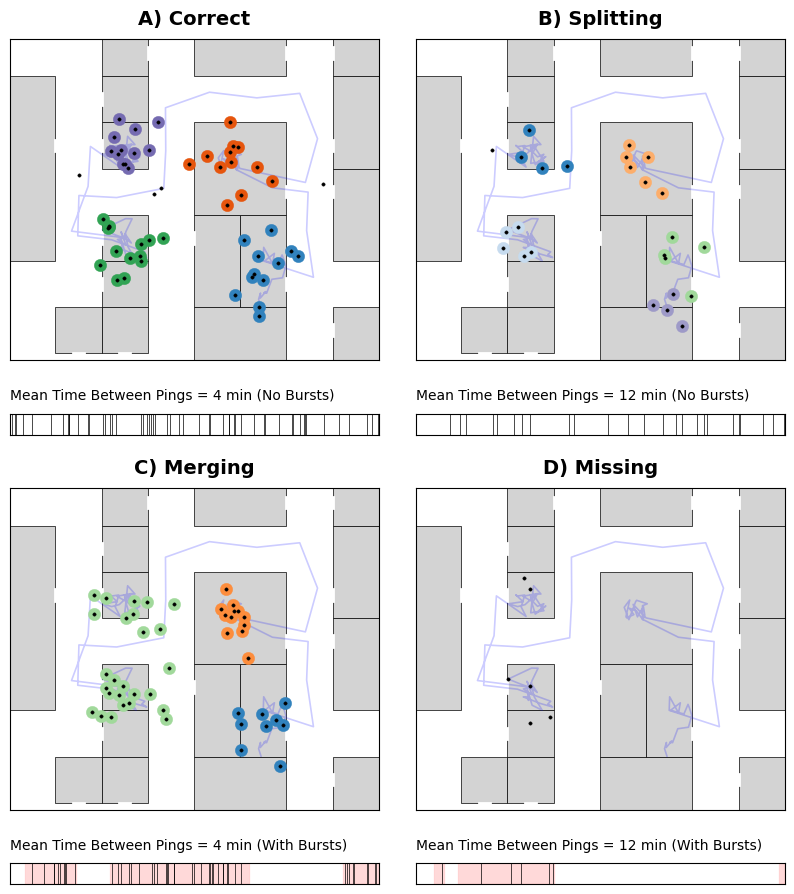

In [7]:
fig, axes = plt.subplots(
    4, 2, figsize=(10, 11),
    gridspec_kw={'height_ratios': [4.7, 0.3, 4.7, 0.3], 'hspace': 0.3, 'wspace': 0.1})
colors = {'home': 'lightgrey','work': 'lightgrey', 'retail': 'lightgrey', 'park': 'lightgrey'}

Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)
Charlie.generate_trajectory(destination_diary=destinations, seed=2025, dt=0.25)

# --- Top Left Subplot: Correct ---
Charlie.sample_trajectory(beta_start=None,
                          beta_durations=None,
                          beta_ping=4,
                          seed=2311,
                          ha=3/5,
                          replace_sparse_traj=True,
                          deduplicate=True)
labels = TADBSCAN._temporal_dbscan_labels(
    data=Charlie.sparse_traj,
    time_thresh=600,
    dist_thresh=0.8,
    min_pts=3,
    dur_min=5,
    traj_cols=traj_cols)

city.plot_city(axes[0, 0], doors=True, address=False, zorder=0, colors=colors)
viz.plot_sparse_clusters(Charlie.sparse_traj, labels.cluster, axes[0, 0],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[0, 0].set_title('A) Correct', fontsize=14, pad=10, fontweight='bold')

# Barcode
timestamps = Charlie.sparse_traj.timestamp
axes[1, 0].set(xlim=(1717214400, 1717228800))
axes[1, 0].vlines(timestamps, ymin=0, ymax=1, colors='black', lw=0.5)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_yticks([])
axes[1, 0].set_xticks([])
axes[1, 0].set_yticklabels([])
axes[1, 0].set_title('Mean Time Between Pings = 4 min (No Bursts)', fontsize=10, pad=10, loc='left')

# --- Top Right Subplot: Splitting ---
Charlie.sample_trajectory(beta_start=None,
                          beta_durations=None,
                          beta_ping=12,
                          seed=7617,
                          ha=3/5,
                          replace_sparse_traj=True,
                          deduplicate=True)
labels = LACHESIS._lachesis_labels(
    traj=Charlie.sparse_traj,
    dt_max=600,
    delta_roam=1.5,
    dur_min=5,
    traj_cols=traj_cols)

city.plot_city(axes[0, 1], doors=True, address=False, zorder=0, colors=colors)
viz.plot_sparse_clusters(Charlie.sparse_traj, labels, axes[0, 1],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[0, 1].set_title('B) Splitting', fontsize=14, pad=10, fontweight='bold')

# Barcode
timestamps = Charlie.sparse_traj.timestamp
axes[1, 1].set(xlim=(1717214400, 1717228800))
axes[1, 1].vlines(timestamps, ymin=0, ymax=1, colors='black', lw=0.5)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_yticks([])
axes[1, 1].set_xticks([])
axes[1, 1].set_yticklabels([])
axes[1, 1].set_title('Mean Time Between Pings = 12 min (No Bursts)', fontsize=10, pad=10, loc='left')

# --- Bottom Left Subplot: Merging ---
burst_info = Charlie.sample_trajectory(beta_start=90,
                                       beta_durations=45,
                                       beta_ping=4,
                                       seed=3351,
                                       ha=3/5,
                                       replace_sparse_traj=True,
                                       deduplicate=True,
                                       output_bursts=True)
labels = TADBSCAN._temporal_dbscan_labels(
    data=Charlie.sparse_traj,
    time_thresh=600,
    dist_thresh=1,
    min_pts=3,
    dur_min=5,
    traj_cols=traj_cols)

city.plot_city(axes[2, 0], doors=True, address=False, zorder=0, colors=colors)
viz.plot_sparse_clusters(Charlie.sparse_traj, labels.cluster, axes[2, 0],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[2, 0].set_title('C) Merging', fontsize=14, pad=10, fontweight='bold')

# Barcode
timestamps = Charlie.sparse_traj.timestamp
axes[3, 0].set(xlim=(1717214400, 1717228800))
for _, row in burst_info.iterrows():
    axes[3, 0].fill_betweenx([0, 1], int(row['start_time'].timestamp()), int(row['end_time'].timestamp()), 
                             color='red', alpha=0.15)
axes[3, 0].vlines(timestamps, ymin=0, ymax=1, colors='black', lw=0.5)
axes[3, 0].set_ylim(0, 1)
axes[3, 0].set_yticks([])
axes[3, 0].set_xticks([])
axes[3, 0].set_yticklabels([])
axes[3, 0].set_title('Mean Time Between Pings = 4 min (With Bursts)', fontsize=10, pad=10, loc='left')

# --- Bottom Right Subplot: Missing ---
burst_info = Charlie.sample_trajectory(beta_start=90,
                                       beta_durations=45,
                                       beta_ping=12,
                                       seed=8758,
                                       ha=3/5,
                                       replace_sparse_traj=True,
                                       deduplicate=True,
                                       output_bursts=True)
labels = TADBSCAN._temporal_dbscan_labels(
    data=Charlie.sparse_traj,
    time_thresh=600,
    dist_thresh=0.8,
    min_pts=3,
    dur_min=5,
    traj_cols=traj_cols)

city.plot_city(axes[2, 1], doors=True, address=False, zorder=0, colors=colors)
viz.plot_sparse_clusters(Charlie.sparse_traj, labels.cluster, axes[2, 1],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[2, 1].set_title('D) Missing', fontsize=14, pad=10, fontweight='bold')

# Barcode
timestamps = Charlie.sparse_traj.timestamp
axes[3, 1].set(xlim=(1717214400, 1717228800))
for _, row in burst_info.iterrows():
    axes[3, 1].fill_betweenx([0, 1], int(row['start_time'].timestamp()), int(row['end_time'].timestamp()), 
                             color='red', alpha=0.15)
axes[3, 1].vlines(timestamps, ymin=0, ymax=1, colors='black', lw=0.5)
axes[3, 1].set_ylim(0, 1)
axes[3, 1].set_yticks([])
axes[3, 1].set_xticks([])
axes[3, 1].set_yticklabels([])
axes[3, 1].set_title('Mean Time Between Pings = 12 min (With Bursts)', fontsize=10, pad=10, loc='left')

plt.tight_layout()
plt.savefig("all-problems.png", dpi=800, bbox_inches='tight')
plt.show()

## Experiment 1.1

Demonstrates merging. We specify four neighboring small stops.

In [8]:
start_time = pd.date_range(start='2024-06-01 00:00-04:00', periods=4, freq='60min')
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1 + ['w-x18-y10'] * 1 + ['w-x18-y8'] * 1

destinations = pd.DataFrame(
    {"datetime":start_time,
     "timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destinations = tg.condense_destinations(destinations)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp',
             'location_id':'building_id'}

Example plot

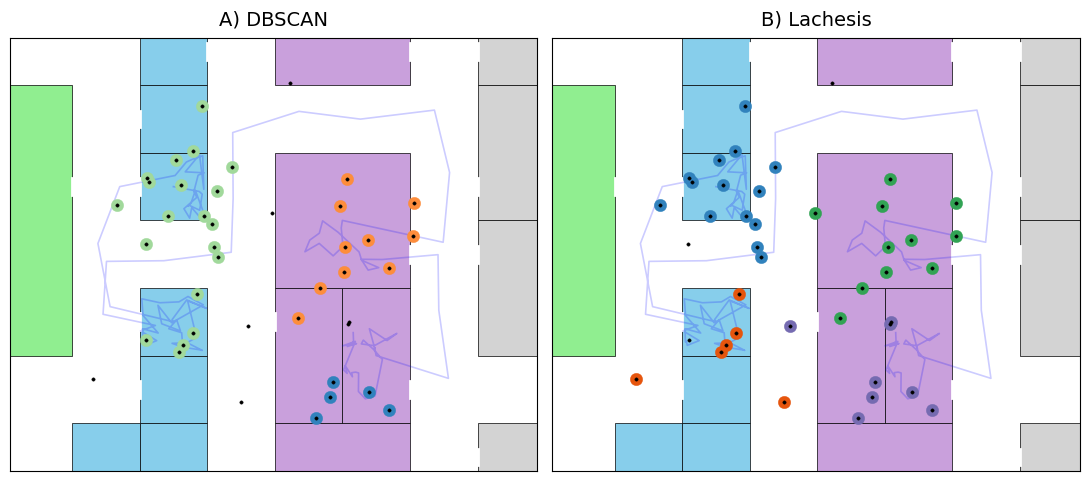

In [9]:
Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destinations, seed=234, dt=0.25)
Charlie.sample_trajectory(beta_start=None,
                          beta_durations=None,
                          beta_ping=6,
                          seed=2,
                          ha=3/4,
                          replace_sparse_traj=True,
                          deduplicate=True)

dbscan_labels = TADBSCAN._temporal_dbscan_labels(
    data=Charlie.sparse_traj,
    time_thresh=600,
    dist_thresh=0.8,
    min_pts=3,
    dur_min=5,
    traj_cols=traj_cols)

lachesis_labels = LACHESIS._lachesis_labels(
    traj=Charlie.sparse_traj,
    dt_max=600,
    delta_roam=2.5,
    dur_min=5,
    traj_cols=traj_cols)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# --- Left Subplot: DBSCAN ---
city.plot_city(axes[0], doors=True, address=False, zorder=0)
viz.plot_sparse_clusters(Charlie.sparse_traj, dbscan_labels.cluster, axes[0],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[0].set_title('A) DBSCAN', fontsize=14, pad=10)

# --- Right Subplot: Lachesis ---
city.plot_city(axes[1], doors=True, address=False, zorder=0)
viz.plot_sparse_clusters(Charlie.sparse_traj, lachesis_labels, axes[1],
                        full_traj=Charlie.trajectory, buffer=0.5)
axes[1].set_title('B) Lachesis', fontsize=14, pad=10)

plt.tight_layout()
plt.savefig("exp1-merging.png", dpi=300, bbox_inches='tight')
plt.show()

Set up simulation parameters

In [10]:
BETA_START = [None]  # One long burst
BETA_DUR = [None]    # One long burst
BETA_PING = np.arange(2, 25.5, 0.5).tolist()   # Range of mean inter-ping times
ALGOS = ['ta-dbscan', 'lachesis']   # Algorithms to run
HOR_ACC = [3/4]   # All trajectories have the same horizontal accuracy

# DBScan and Lachesis are run with the following parameters
dbscan_param = dict(time_thresh=600, dist_thresh=0.8, min_pts=3, dur_min=5)
lachesis_param = dict(dur_min=5, dt_max=600, delta_roam=2)

# Generate all combinations of simulation parameters
sim_tasks = list(itertools.product(
    BETA_START,
    BETA_DUR,
    BETA_PING,
    ALGOS,
    HOR_ACC
))

N_sim = 1000  # Number of times to run each combination in sim_tasks (i.e., number of seeds)

sim_tasks = pd.DataFrame(sim_tasks, columns=['beta_start', 'beta_dur', 'beta_ping', 'algorithm', 'ha'])

The following code parallelizes the simulation. Run it on Sagemaker.

In [ ]:
# PARALLELIZED CODE (RUN ON SAGEMAKER)

if __name__ == '__main__':

    # Specify agent-specific simulation parameters (all agents have will these parameters)
    dt = 0.25
    agent_home='h-x13-y11'
    agent_workplace='w-x18-y8'

    seeds_to_run = range(N_sim)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (seed, dt, sim_tasks, agent_home, agent_workplace, destinations, 
         dbscan_param, lachesis_param, traj_cols, summarize_stops_with_loc)
        for seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_seed, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp1a_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

In [11]:
# Load the results from the pickle file
with open('exp1a_results.pkl', 'rb') as f:
    results = pickle.load(f)
    all_metrics_df = results['all_metrics']
    metrics_size_df = results['metrics_size']
    metrics_btype_df = results['metrics_btype']
    metrics_dwell_df = results['metrics_dwell']

Create Exp 1a plot:

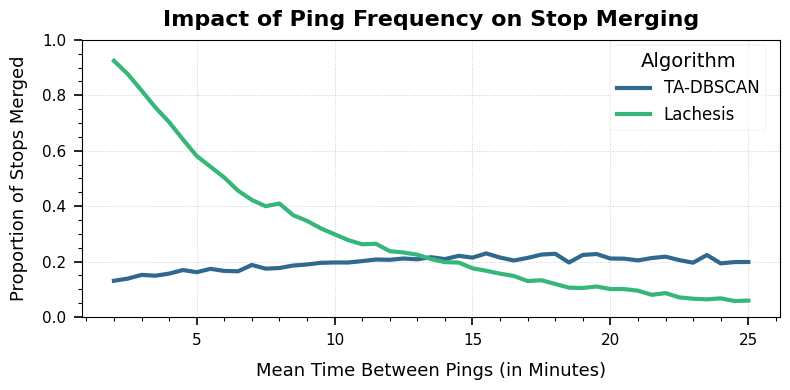

In [12]:
# Prepare the DataFrame for plotting
chart_df1 = all_metrics_df.groupby(['beta_ping', 'algorithm'])['merged_fraction'].agg(['mean', 'sem']).reset_index()
chart_df1.rename(columns={'mean': 'merged_fraction_mean', 'sem': 'merged_fraction_sem'}, inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(
    data=chart_df1,
    x='beta_ping',
    y='merged_fraction_mean',
    hue='algorithm',
    marker='',
    linewidth=3,
    ax=ax,
    palette='viridis'
)

ax.set_title('Impact of Ping Frequency on Stop Merging', fontsize=16, pad=10, fontweight='bold')
ax.set_xlabel('Mean Time Between Pings (in Minutes)', fontsize=13, labelpad=10)
ax.set_ylabel('Proportion of Stops Merged', fontsize=13, labelpad=10)

handles, labels = ax.get_legend_handles_labels()
labels = ['TA-DBSCAN', 'Lachesis']
ax.legend(title='Algorithm', labels=labels, handles=handles,
          bbox_to_anchor=(0.98, 0.98), loc='upper right', 
          borderaxespad=0., fontsize=12, title_fontsize=14, frameon=True)

ax.grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1.2)
ax.tick_params(axis='both', which='minor', length=3, width=0.8)
ax.minorticks_on() 

ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("exp1a-merging.png")

plt.show()

## Experiment 1.2

Demonstrates splitting and missing. We specify 5 stops of varying areas and dwell times.

In [13]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 03:00', periods=18, freq='60min', tz=tz)
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*18  # in minutes
location = ['h-x13-y6'] * 7 + ['r-x15-y0'] * 1 + ['w-x18-y13'] * 6 + ['r-x18-y5'] * 1 + ['p-x13-y11'] * 3

destinations = pd.DataFrame(
    {"datetime":start_time,
     "timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destinations = tg.condense_destinations(destinations)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp',
             'location_id':'building_id'}

Example plot

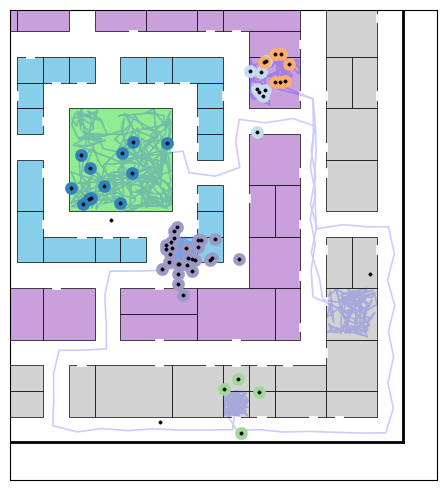

In [14]:
algo = 'ta-dbscan'  # or 'lachesis'

Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destinations, dt=0.25, seed=300)
Charlie.sample_trajectory(*(20, 45, 10), seed=300, replace_sparse_traj=True)

if algo == 'ta-dbscan':
    labels = TADBSCAN._temporal_dbscan_labels(
        data=Charlie.sparse_traj,
        time_thresh=90,
        dist_thresh=2,
        min_pts=2,
        traj_cols=traj_cols)
    
elif algo == 'lachesis':
    labels = LACHESIS._lachesis_labels(
        traj=Charlie.sparse_traj,
        dt_max=20,
        delta_roam=75,
        dur_min=2,
        traj_cols=traj_cols)
    
labels.name = 'cluster'
sparse_with_cluster = Charlie.sparse_traj.join(labels)

pred = visits.point_in_polygon(
    data=sparse_with_cluster,
    poi_table=poi_table,
    method='majority',
    data_crs='EPSG:4326',
    max_distance=15,
    cluster_label='cluster',
    location_id='building_id',
    x='x',
    y='y')

pred = sparse_with_cluster.join(pred)
stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(
    summarize_stops_with_loc, include_groups=False)

fig, ax = plt.subplots(figsize=(9, 5))
city.plot_city(ax, doors=True, address=False, zorder=0)

viz.plot_sparse_clusters(
    Charlie.sparse_traj, 
    labels.cluster, # or simply `labels``, if Lachesis
    ax,
    full_traj=Charlie.trajectory, 
    buffer=0.25)

# plt.savefig("exp2-splitting-dbscan.png")
plt.show()

Set up simulation parameters

In [15]:
EXP_Q = 0.4   # Expected completeness of the trajectory (i.e., the q value)
BETA_START = np.arange(10, 200, 10)   # Range of beta_start values (in minutes)
BETA_PING = [10]   # All trajectories have the same beta_ping
ALGOS = ['ta-dbscan', 'lachesis']
HOR_ACC = [3/4]   # All trajectories have the same horizontal accuracy

# DBScan and Lachesis are run with the following parameters
dbscan_param = dict(time_thresh=90, dist_thresh=1.2, min_pts=2, dur_min=5)
lachesis_param = dict(dur_min=5, dt_max=90, delta_roam=2)

# Generate all combinations of simulation parameters
sim_tasks = list(itertools.product(
    BETA_START,
    BETA_PING,
    ALGOS,
    HOR_ACC
))
sim_tasks = pd.DataFrame(sim_tasks, columns=['beta_start', 'beta_ping', 'algorithm', 'ha'])
sim_tasks['beta_dur'] = sim_tasks['beta_start'] * EXP_Q   # Compute beta_dur based on the expected q value

N_sim = 1000  # Number of times to run each simulation task (i.e., number of seeds)

agent = Agent(
    identifier="Charlie",
    home='h-x13-y11',
    workplace='w-x18-y8',
    city=city)

The following code parallelizes the simulation. Run it on Sagemaker.

In [ ]:
# PARALLELIZED CODE (RUN ON SAGEMAKER)

if __name__ == '__main__':

    # Specify agent-specific simulation parameters (all agents have will these parameters)
    dt_val = 0.25
    agent_home='h-x13-y11'
    agent_workplace='w-x18-y8'

    seeds_to_run = range(N_sim)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (seed, dt_val, sim_tasks, agent_home, agent_workplace, destinations,
         dbscan_param, lachesis_param, traj_cols, summarize_stops_with_loc)
        for seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_seed, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp1b_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

In [16]:
# Load the results from the pickle file
with open('exp1b_results.pkl', 'rb') as f:
    results = pickle.load(f)
    all_metrics_df = results['all_metrics']
    metrics_size_df = results['metrics_size']
    metrics_btype_df = results['metrics_btype']
    metrics_dwell_df = results['metrics_dwell']

Create Exp 1b plot:

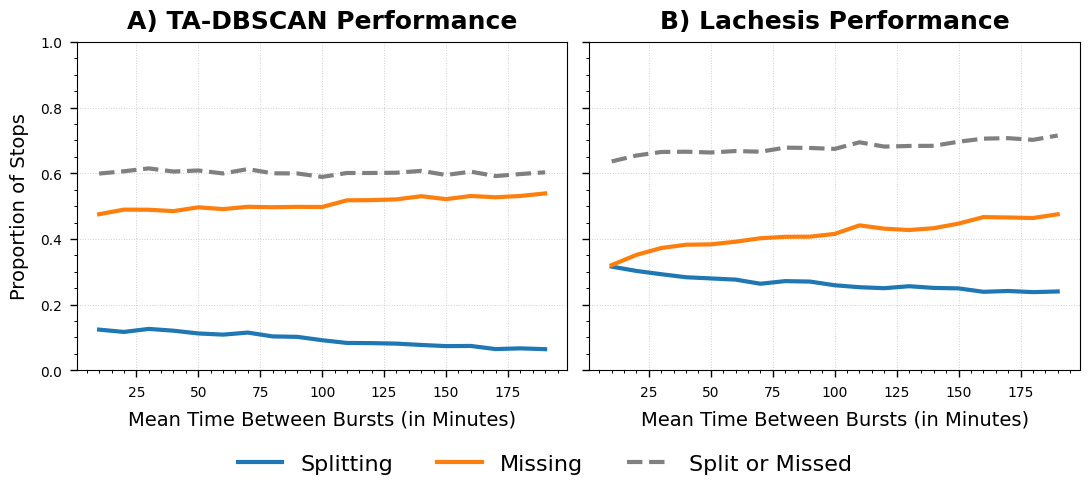

In [17]:
# Calculate mean and standard error of the mean for each metric
chart_df2 = all_metrics_df.groupby(['beta_start', 'algorithm']).agg(
    split_fraction_mean=('split_fraction', 'mean'),
    split_fraction_sem=('split_fraction', 'sem'),
    missed_fraction_mean=('missed_fraction', 'mean'),
    missed_fraction_sem=('missed_fraction', 'sem')
).reset_index()

chart_df2['both_mean'] = chart_df2['split_fraction_mean'] + chart_df2['missed_fraction_mean']
chart_df2['both_sem'] = (chart_df2['split_fraction_sem']**2 + chart_df2['missed_fraction_sem']**2)**0.5

chart_df2_dbscan = chart_df2[chart_df2.algorithm == 'ta-dbscan']
chart_df2_lachesis = chart_df2[chart_df2.algorithm == 'lachesis']

# --- Charting ---
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
colors = sns.color_palette("tab10", n_colors=3)

# Plot for DBSCAN (Left Subplot)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='split_fraction_mean',
    ax=axes[0],
    #label='Splitting',
    marker='',
    linewidth=3,
    color=colors[0],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='missed_fraction_mean',
    ax=axes[0],
    #label='Missing',
    marker='',
    linewidth=3,
    color=colors[1],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='both_mean',
    ax=axes[0],
    #label='Split or Missed',
    linestyle='--',
    linewidth=3,
    color='gray',
    marker='',
    errorbar='se'
)

axes[0].set_title('A) TA-DBSCAN Performance', fontsize=18, pad=10, fontweight='bold')
axes[0].set_xlabel('Mean Time Between Bursts (in Minutes)', fontsize=14, labelpad=8)
axes[0].set_ylabel('Proportion of Stops', fontsize=14, labelpad=8)
axes[0].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[0].set_ylim(0, 1)

# Plot for Lachesis (Right Subplot)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='split_fraction_mean',
    ax=axes[1],
    #label='Splitting',
    marker='',
    linewidth=3,
    color=colors[0],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='missed_fraction_mean',
    ax=axes[1],
    #label='Missing',
    marker='',
    linewidth=3,
    color=colors[1],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='both_mean',
    ax=axes[1],
    #label='Split or Missed',
    linestyle='--',
    linewidth=3,
    color='gray',
    marker='',
    errorbar='se'
)
axes[1].set_title('B) Lachesis Performance', fontsize=18, pad=10, fontweight='bold')
axes[1].set_xlabel('Mean Time Between Bursts (in Minutes)', fontsize=14, labelpad=8)
axes[1].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[1].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[1].minorticks_on()
axes[1].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[1].set_ylim(0, 1)

legend_labels = ['Splitting', 'Missing', 'Split or Missed']
handles = [
    axes[0].lines[0],
    axes[0].lines[1],
    axes[0].lines[2]
]
fig.legend(
    handles,
    legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    ncol=len(legend_labels),
    fontsize=16,
    title_fontsize=18,
    frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("exp1b-splitting-missing.png", dpi=300, bbox_inches='tight')

plt.show()

## Experiment 2

For each of (100?) agents with heterogeneous noise and sparsity patterns, we will generate multiple 3-week-long ground-truth trajectories and sample sparse traces. 

### Define simulation code for exp 2

In [18]:
summarize_stops_with_loc = partial(
    utils.summarize_stop,
    x='x',
    y='y',
    keep_col_names=False,
    passthrough_cols=['building_id'],
    complete_output=True)

def run_simulation_for_single_agent(
    agent_seed, dt, N_sim, dbscan_param, lachesis_param, 
    traj_cols, poi_table, city, summarize_stops_with_loc
):
    """
    This function performs the simulation for a single 'agent'.
    It's designed to be run in a separate process for parallelization.
    """
    # Initialize DataFrames to store metrics for this seed
    seed_all_metrics_df = pd.DataFrame()
    seed_metrics_size_df = pd.DataFrame()
    seed_metrics_btype_df = pd.DataFrame()
    seed_metrics_dwell_df = pd.DataFrame()

    agent = Agent(
        identifier="Charlie",
        city=city,
        seed=agent_seed
    )
    agent.generate_trajectory(
        datetime = "2024-01-01T08:00 -04:00",
        end_time = pd.Timestamp('2024-01-21T08:30:00 -04:00'),
        seed=agent_seed,
        dt=dt)

    # Get ground-truth diary
    truth = agent.diary.copy()
    truth = truth[truth['location'].notna()]
    truth = truth.rename(columns={'location': 'building_id'})
    truth['building_size'] = truth['building_id'].apply(classify_building_size_from_id)
    truth['building_type'] = truth['building_id'].apply(classify_building_type_from_id)
    truth['dwell_length'] = truth['duration'].apply(classify_dwell)

    beta_params = gen_params_target_q(q_range=(0.4, 0.85), seed=agent_seed)
    ha = np.random.uniform(10/15, 16/15, size=1)[0]

    # Iterate over simulation configurations
    for i in range(N_sim):
        for algo in ['oracle', 'ta-dbscan', 'lachesis']:

            # Extract simulation configuration
            beta_start = beta_params['beta_start']
            beta_dur = beta_params['beta_durations']
            beta_ping = beta_params['beta_ping']
            algo = algo
            ha = ha

            # Sample sparse trajectory
            agent.sample_trajectory(
                beta_start,
                beta_dur,
                beta_ping,
                seed=i,
                ha=ha,
                replace_sparse_traj=True)
            sparse = agent.sparse_traj.copy()

            # Compute completeness (q)
            # q = filters.q_stats(sparse, traj_cols=traj_cols)
            # q = q.loc[0, 'q_stat']
            # the underlying code in the filters package has changed ...
            # fix in accordance with the new method to extract the q of a single trajectory
            q = None

            # ----------- RUN STOP DETECTION -----------
            if algo == 'oracle':
                TIME_THRESH = dbscan_param['time_thresh']  # should be the same for dbscan and lachesis

                # oracle says correct poi for each ping
                location = visits.oracle_map(
                    sparse,
                    truth,
                    timestamp='timestamp',
                    location_id='building_id')
                # find cluster labels with naive grid-based continuity
                labels = GRID_BASED.grid_based_labels(
                    data=sparse.join(location),
                    time_thresh=TIME_THRESH,
                    min_pts=0, #we allow stops of duration 0, patched later
                    location_id='building_id',
                    traj_cols=traj_cols)

            elif algo == 'ta-dbscan':
                TIME_THRESH = dbscan_param['time_thresh']
                DIST_THRESH = dbscan_param['dist_thresh']
                MIN_PTS = dbscan_param['min_pts']
                DUR_MIN = dbscan_param['dur_min']

                labels = TADBSCAN._temporal_dbscan_labels(
                    data=sparse,
                    time_thresh=TIME_THRESH,
                    dist_thresh=DIST_THRESH,
                    min_pts=MIN_PTS,
                    dur_min=DUR_MIN,
                    traj_cols=traj_cols)
                labels.name = 'cluster'
                sparse_with_cluster = sparse.join(labels)

            elif algo == 'lachesis':
                TIME_THRESH = lachesis_param['dt_max']
                DELTA_ROAM = lachesis_param['delta_roam']
                DUR_MIN = lachesis_param['dur_min']

                labels = LACHESIS._lachesis_labels(
                    traj=sparse,
                    dt_max=TIME_THRESH,
                    dur_min=DUR_MIN,
                    delta_roam=DELTA_ROAM,
                    traj_cols=traj_cols)
                labels.name = 'cluster'
                sparse_with_cluster = sparse.join(labels)

            else:
                print(f"Algorithm {algo} not in the list!")
                continue 

            # ----------- COMPUTE STOPS FROM LABELS -----------

            if algo != 'oracle':
                pred = visits.point_in_polygon(
                    data=sparse_with_cluster,
                    poi_table=poi_table,
                    method='majority',
                    data_crs='EPSG:4326',
                    max_distance=15,
                    cluster_label='cluster',
                    location_id='building_id',
                    x='x',
                    y='y')

                pred = sparse_with_cluster.join(pred)
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(
                    summarize_stops_with_loc, include_groups=False)

            # ----------- REMOVING OVERLAPS (POST PROCESSING) -----------

                if stops.empty:
                    expected_stop_columns = [
                        'cluster', 'x', 'y', 'start_timestamp', 'ha', 'diameter', 'n_pings',
                        'end_timestamp', 'duration', 'max_gap', 'building_id']
                    stops = pd.DataFrame(columns=expected_stop_columns)

                try:
                    utils.invalid_stops(stops)
                except Exception: 
                    stops = pp.remove_overlaps(
                        pred,
                        time_thresh=TIME_THRESH,
                        min_pts=MIN_PTS,
                        dur_min=DUR_MIN,
                        traj_cols=traj_cols,
                        post_processing='polygon')

                stops['building_id'] = stops['building_id'].astype(str)
                
                if stops.empty:
                    expected_stop_columns = [
                        'cluster', 'x', 'y', 'start_timestamp', 'duration', 'building_id']
                    stops = pd.DataFrame(columns=expected_stop_columns)

            else:  # location exists by oracle, we join everything
                pred = sparse.join(location).join(labels)
                stops = pred[pred.cluster!=-1].groupby(
                    'cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
                # we add a 5min duration to oracle stops with just one ping
                stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp')

            first_time = truth['timestamp'].iloc[0]
            last_time = truth['timestamp'].iloc[-1] + truth['duration'].iloc[-1] * 60
            stops_filled = pp.fill_timestamp_gaps(first_time, last_time, stops)

            # ----------- COMPUTE METRICS OF INTEREST -----------

            # general metrics
            overlaps = overlapping_visits(
                left=stops,
                right=truth,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled, 
                right=truth, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops,
                true_visits=truth,
                location_id='building_id')

            all_metrics = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'agent': agent_seed, 'seed': i, 'algorithm': algo, 
                           'noise': ha, 'q': q}
            seed_all_metrics_df = pd.concat([seed_all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

            # size metrics
            stops_attr = stops.merge(
                poi_table[['building_id', 'building_size', 'building_type']], on='building_id')
            stops_filled_attr = stops_filled.merge(
                poi_table[['building_id', 'building_size', 'building_type']], on='building_id')

            for build_size in ['small', 'medium', 'big']:
                if (truth.building_size==build_size).sum()==0:
                    continue

                truth_subset = truth.loc[truth.building_size==build_size]

                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)

                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)

                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')

                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')

                metrics_size = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'agent': agent_seed, 'seed': i, 'algorithm': algo, 
                           'noise': ha, 'q': q}
                seed_metrics_size_df = pd.concat([seed_metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

            # btype metrics
            for building_type in ['home', 'retail', 'work', 'park']:
                if (truth.building_type==building_type).sum() == 0:
                    continue

                truth_subset = truth.loc[truth.building_type==building_type]

                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)

                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)

                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')

                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')

                metrics_btype = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'agent': agent_seed, 'seed': i, 'algorithm': algo, 
                           'noise': ha, 'q': q}
                seed_metrics_btype_df = pd.concat([seed_metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

            # dwell metrics
            for dwell_length in ['low', 'mid', 'high']:    
                if (truth.dwell_length==dwell_length).sum() == 0:
                    continue

                truth_subset = truth.loc[truth.dwell_length==dwell_length]

                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)

                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)

                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')

                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')

                metrics_dwell = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'agent': agent_seed, 'seed': i, 'algorithm': algo, 
                           'noise': ha, 'q': q}
                seed_metrics_dwell_df = pd.concat([seed_metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)

    print(f"Finished simulation for seed {agent_seed} on process {os.getpid()}")
    return seed_all_metrics_df, seed_metrics_size_df, seed_metrics_btype_df, seed_metrics_dwell_df

### Run Exp 2

In [19]:
N_agents = 100   # number of agents to simulate
N_sim = 10  # number of simulations per agent

# DBScan and Lachesis are run with the following parameters
dbscan_param = dict(time_thresh=600, dist_thresh=0.8, min_pts=3, dur_min=5)
lachesis_param = dict(dur_min=5, dt_max=600, delta_roam=2)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp',
             'location_id':'building_id'}

In [ ]:
# PARALLELIZED CODE (RUN ON SAGEMAKER)

if __name__ == '__main__':

    dt_val = 0.25

    seeds_to_run = range(1, N_agents+1)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (agent_seed, dt_val, N_sim, dbscan_param, lachesis_param, 
         traj_cols, poi_table, city, summarize_stops_with_loc)
        for agent_seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_agent, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp2_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

In [20]:
# Load the results from the pickle file
with open('exp2_results.pkl', 'rb') as f:
    results = pickle.load(f)
    all_metrics_df = results['all_metrics']
    metrics_size_df = results['metrics_size']
    metrics_btype_df = results['metrics_btype']
    metrics_dwell_df = results['metrics_dwell']

Summary table of metrics (outputted in in LaTeX)

In [21]:
summary = all_metrics_df.groupby('algorithm')[['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']].mean()
summary.columns = ['missed', 'merged', 'split', 'precision', 'recall', 'f1']
print(summary.to_latex(float_format="%.3f", caption="Stop Detection Metrics by Algorithm", label="tab:exp2_metrics"))

\begin{table}
\caption{Stop Detection Metrics by Algorithm}
\label{tab:exp2_metrics}
\begin{tabular}{lrrrrrr}
\toprule
 & missed & merged & split & precision & recall & f1 \\
algorithm &  &  &  &  &  &  \\
\midrule
lachesis & 0.620 & 0.052 & 0.149 & 0.997 & 0.362 & 0.524 \\
oracle & 0.498 & 0.038 & 0.001 & 0.997 & 0.449 & 0.611 \\
ta-dbscan & 0.679 & 0.141 & 0.003 & 0.992 & 0.419 & 0.575 \\
\bottomrule
\end{tabular}
\end{table}



Chart

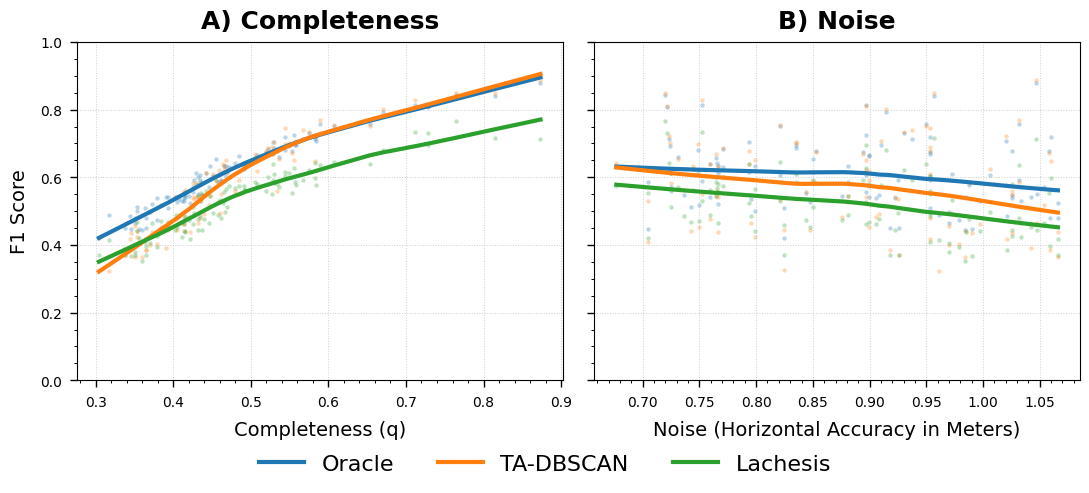

In [22]:
chart_df3 = all_metrics_df.groupby(['agent', 'algorithm']).mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
colors = sns.color_palette("tab10", n_colors=3)

algorithms = ['oracle', 'ta-dbscan', 'lachesis']

# Left Subplot: F1 over Q (Scatter with Line of Best Fit)
for i, algo in enumerate(algorithms):
    algo_data = chart_df3[chart_df3.algorithm == algo]
    
    sns.regplot(
        data=algo_data,
        x='q',
        y='f1',
        ax=axes[0],
        label=algo,
        color=colors[i],
        scatter_kws={'alpha': 0.3, 's': 10},
        line_kws={'lw': 3},
        ci=95,
        lowess=True
    )

axes[0].set_title('A) Completeness', fontsize=18, pad=10, fontweight='bold')
axes[0].set_xlabel('Completeness (q)', fontsize=14, labelpad=8)
axes[0].set_ylabel('F1 Score', fontsize=14, labelpad=8)
axes[0].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[0].set_ylim(0, 1)

# Right Subplot: F1 over Noise (ha) (Scatter with Line of Best Fit)
for i, algo in enumerate(algorithms):
    algo_data = chart_df3[chart_df3.algorithm == algo]

    sns.regplot(
        data=algo_data,
        x='noise',
        y='f1',
        ax=axes[1],
        label=algo,
        color=colors[i],
        scatter_kws={'alpha': 0.3, 's': 10},
        line_kws={'lw': 3},
        ci=95,
        lowess=True
    )

axes[1].set_title('B) Noise', fontsize=18, pad=10, fontweight='bold')
axes[1].set_xlabel('Noise (Horizontal Accuracy in Meters)', fontsize=14, labelpad=8)
axes[1].set_ylabel('')
axes[1].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[1].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[1].minorticks_on()
axes[1].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[1].set_ylim(0, 1)

# for i, algo in enumerate(algorithms):
#     algo_data = chart_df3[chart_df3.algorithm == algo]

#     sns.regplot(
#         data=algo_data,
#         x='beta_ping',
#         y='f1',
#         ax=axes[2],
#         label=algo,
#         color=colors[i],
#         scatter_kws={'alpha': 0.6, 's': 50},
#         line_kws={'lw': 2},
#         ci=95,
#         lowess=True
#     )

# axes[2].set_title('F1 Score vs. Time Between Pings', fontsize=14, pad=10)
# axes[2].set_xlabel('Mean Time Between Pings (Minutes)', fontsize=12, labelpad=8)
# axes[2].set_ylabel('F1 Score', fontsize=12, labelpad=8)
# axes[2].legend(title='Algorithm', fontsize=10, frameon=False)
# axes[2].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
# axes[2].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
# axes[2].minorticks_on()
# axes[2].tick_params(axis='both', which='minor', length=2.5, width=0.7)
# axes[2].set_ylim(0, 1)

legend_labels = ['Oracle', 'TA-DBSCAN', 'Lachesis']
handles = [
    axes[0].lines[0],
    axes[0].lines[1],
    axes[0].lines[2]
]
fig.legend(
    handles,
    legend_labels,
    loc='lower center',         
    bbox_to_anchor=(0.5, 0),
    ncol=len(legend_labels),
    fontsize=16,
    title_fontsize=18,
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig("exp2-f1.png", dpi=300, bbox_inches='tight')

plt.show()

## Methodology

- We explain garden city and how we produced ground truth, heavily referencing the Arxiv version
- We divide in three sections after that
- Possible problems in stop detection
- Are these problems present in real (global) trajectories? + covariates
- Can the parameterizations address these issues?

There are regimes in which certain problems disappear.
- E.g. going from extremely complete signals to very complete signals, might not make a difference in terms of quality---they are both good enough. This analysis could be visualized in a plot with q in the x-axis, showing that for high q and very low q things break down. 
- E.g. a very bad parameterization of DBScan for retail, might obscure a small effect of beta ping on retail. 
- Some problems might mostly affect users that explore a lot (this is application-relevant). 
- Maybe the conclusion is that you need a hierarchical DBScan

We show problems. Can we THEN show solutions? Then maybe we can hint at solutions while describing problems. 

## Global problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

## Parameterization problems

You can truly choose the wrong parameters, and you might want to incorporate user signal parameters and building areas, and whatnot. Quality of algorithms and how to choose. x-axis is parameter of DBScan and y-axis is quality of clusters.
- What would you do with a complete and regular signal? Maybe a "reasonable" DBScan would fail miserably and Lachesis would succeed? min_pts would save the day? 
- Time parameter ranges from 1 hour to 16 hours. Long-dwell "bridging" of huge gaps would increase (obviously) but, the nuance is overestimating time at work or at home. Absolute vs Relative. 
- Epsilon affects splitting and merging. Pick a "default and reasonable" beta_ping and change epsilon. 